## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import sklearn.metrics as metrics
from sklearn.model_selection import cross_validate, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import tree

## Data Preprocessing

First, we read in the datasets.

In [4]:
#| label: dataset-preview
df = pd.read_csv("../data/solar.csv")
df.head(5)

,id,lat,long,state,farm_type,irradiance,lcoe,capacity,capacity_factor,array_area,available_solar_resource,generated_energy,cost
0,0,25.896492,-97.460358,Texas,large_community,5.634079,39,5.00,0.235,90633.862770,21.276596,6132.00,4782960.0
1,1,26.032654,-97.738098,Texas,small_utility,5.616413,39,5.00,0.234,91307.484990,21.367521,6132.00,4782960.0
2,2,26.059063,-97.208252,Texas,small_community,5.746738,39,0.15,0.239,2621.097459,0.627615,183.96,143488.8
3,3,26.078449,-98.073364,Texas,small_utility,5.742196,39,5.00,0.239,87439.036330,20.920502,6132.00,4782960.0
4,4,26.143227,-98.311340,Texas,small_utility,5.817187,39,5.00,0.242,85241.850210,20.661157,6132.00,4782960.0


Now, we must shuffle the datasets to reduce bias.

In [5]:
#| label: shuffled-dataset-preview

df = df.sample(frac=1)
df.head(5)

,id,lat,long,state,farm_type,irradiance,lcoe,capacity,capacity_factor,array_area,available_solar_resource,generated_energy,cost
10040,10040,40.622646,-88.224670,Illinois,large_utility,4.875149,46,2000.000,0.203,4.850174e+07,9852.216749,2452800.000,2.256576e+09
8,8,26.272160,-98.098694,Texas,large_utility,5.734213,39,2000.000,0.239,3.502430e+07,8368.200837,2452800.000,1.913184e+09
8780,8780,35.920979,-94.173492,Arkansas,small_community,5.229300,40,0.150,0.218,3.157930e+03,0.688073,183.960,1.471680e+05
1170,1170,30.879341,-102.244232,Texas,large_utility,6.358545,39,2000.000,0.265,2.848640e+07,7547.169811,2452800.000,1.913184e+09
8433,8433,35.489521,-104.796066,New Mexico,large_residential,6.499249,34,0.015,0.271,2.043949e+02,0.055351,18.396,1.250928e+04


Looking at each dataset, we can identify which variables we want to use for our models.

In [6]:
X = df.loc[:, ['lat','long','capacity']]
y = df.loc[:, ['generated_energy','cost']]

Now we split into training and testing sets, reserving about 80% for training and 20% for testing.

In [7]:
X_train = X[:9500]
X_test = X[9500:]
y_train = y[:9500]
y_test = y[9500:]

Models typically perform better when input values are within a certain range, like [-1, 1] for example. We scale the data points appropriately.

In [8]:
#| label: scaled-data

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train

## Training the Models

Now that the data is pre-processed accordingly, the models can be trained and fit. Here, we set `random state` to zero to ensure consistency between both data sets, and re-runs of the training and fitting.

In [9]:
reg = RandomForestRegressor(random_state=0)
reg.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

With a trained model, predictions can now be made.

In [10]:
preds = reg.predict(X_test)
print("Predicted outputs for solar data:")
print(preds)
print()

Predicted outputs for solar data:
[[6.13200000e+05 5.63285520e+08]
 [1.83960000e+02 1.25092800e+05]
 [1.83960000e+02 1.43488800e+05]
 ...
 [2.45280000e+03 2.09714400e+06]
 [6.13200000e+03 4.16976000e+06]
 [1.83960000e+01 1.91943864e+04]]



## Testing and Analyzing the Models

This section contains metrics gathering and other figures that visualize the models and its results.

### Metrics

#### Scores and Error Values

The score being recored are the R2 score, Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE).

In [12]:
#| label: metrics

r2 = metrics.r2_score(y_test, preds, multioutput="raw_values")
rmse = metrics.root_mean_squared_error(y_test, preds, multioutput="raw_values")
mape = metrics.mean_absolute_percentage_error(y_test, preds, multioutput="raw_values")

print("Metric\tScore")
print("-----------------------")
print(f"r2\t{r2}\nrmse\t{rmse}\nmape\t{mape}")

Metric	Score
-----------------------
r2	[1.         0.99947607]
rmse	[1.91189888e-12 1.39046156e+07]
mape	[9.56580122e-16 4.41261849e-03]


#### Feature Importances

Feature importances give insights into the features that each decision tree in the random forest use to split most often. Results are portrayed in percentages.

In [13]:
#| label: feature-importances

features = ['lat','long','capacity']

importances = reg.feature_importances_
indices = np.argsort(importances)

print("Importances")
print('----------------------')
for i in indices:
    print(f"{features[i]}: {importances[i]*100}")

Importances
----------------------
long: 0.505188939207155
lat: 0.7024291549981301
capacity: 98.79238190579471


#### K-Fold Cross Validation

This cross validation splits up the dataset into 10 unique folds, which are then used to test a model. The model is then scored using the same metrics outlined above: R2, RMSE, MAPE. This ensures the scoring is rigorous, and the *entire* dataset is used.

In [14]:
#| label: k-fold-cross-validation-table

kf = KFold(n_splits=10, random_state=0, shuffle=True)
kf_cv_scores = cross_validate(reg, X, y, cv=kf, scoring={"r2":metrics.make_scorer(score_func=metrics.r2_score),
 "rmse":metrics.make_scorer(score_func=metrics.root_mean_squared_error),
 "mape":metrics.make_scorer(score_func=metrics.mean_absolute_percentage_error)})
kf_cv_df = pd.DataFrame.from_dict(kf_cv_scores)
print("10-Fold Cross Validation Scores")
kf_cv_df

10-Fold Cross Validation Scores
----------------------------------------------------


,fit_time,score_time,test_r2,test_rmse,test_mape
0,1.638374,0.015321,0.999770,6.352630e+06,0.001672
1,1.624421,0.016007,0.999724,7.401187e+06,0.001804
2,1.629294,0.015004,0.999623,7.975028e+06,0.002410
3,1.613128,0.014003,0.999741,6.731193e+06,0.001724
4,1.611321,0.015933,0.999406,1.012685e+07,0.002391
5,1.625688,0.015003,0.999964,2.544980e+06,0.001742
6,1.614740,0.015003,0.999825,5.758486e+06,0.002114
7,1.634046,0.015003,0.999757,6.779181e+06,0.002301
8,1.611521,0.015001,0.999797,6.285933e+06,0.001680
9,1.622159,0.015003,0.999858,5.004754e+06,0.001796


### Graphs

A graph of the feature importances. This helps to visualize the magnitude of importance of each feature, and compare their impact against one another.

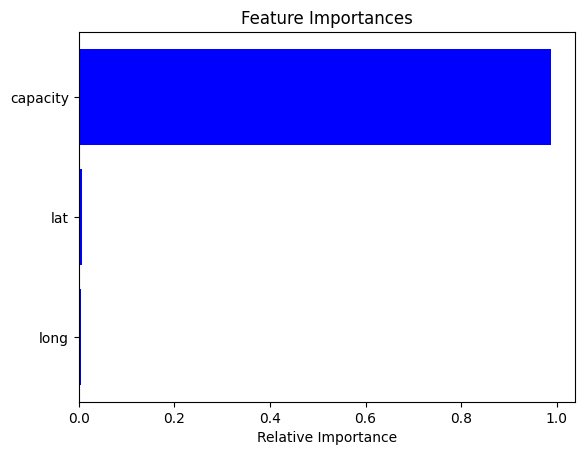

In [15]:
#| label: fig-feature-importances

plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

A graph of one of the decision trees in the random forest. This displays the decision making process the model takes to arive at predictions.

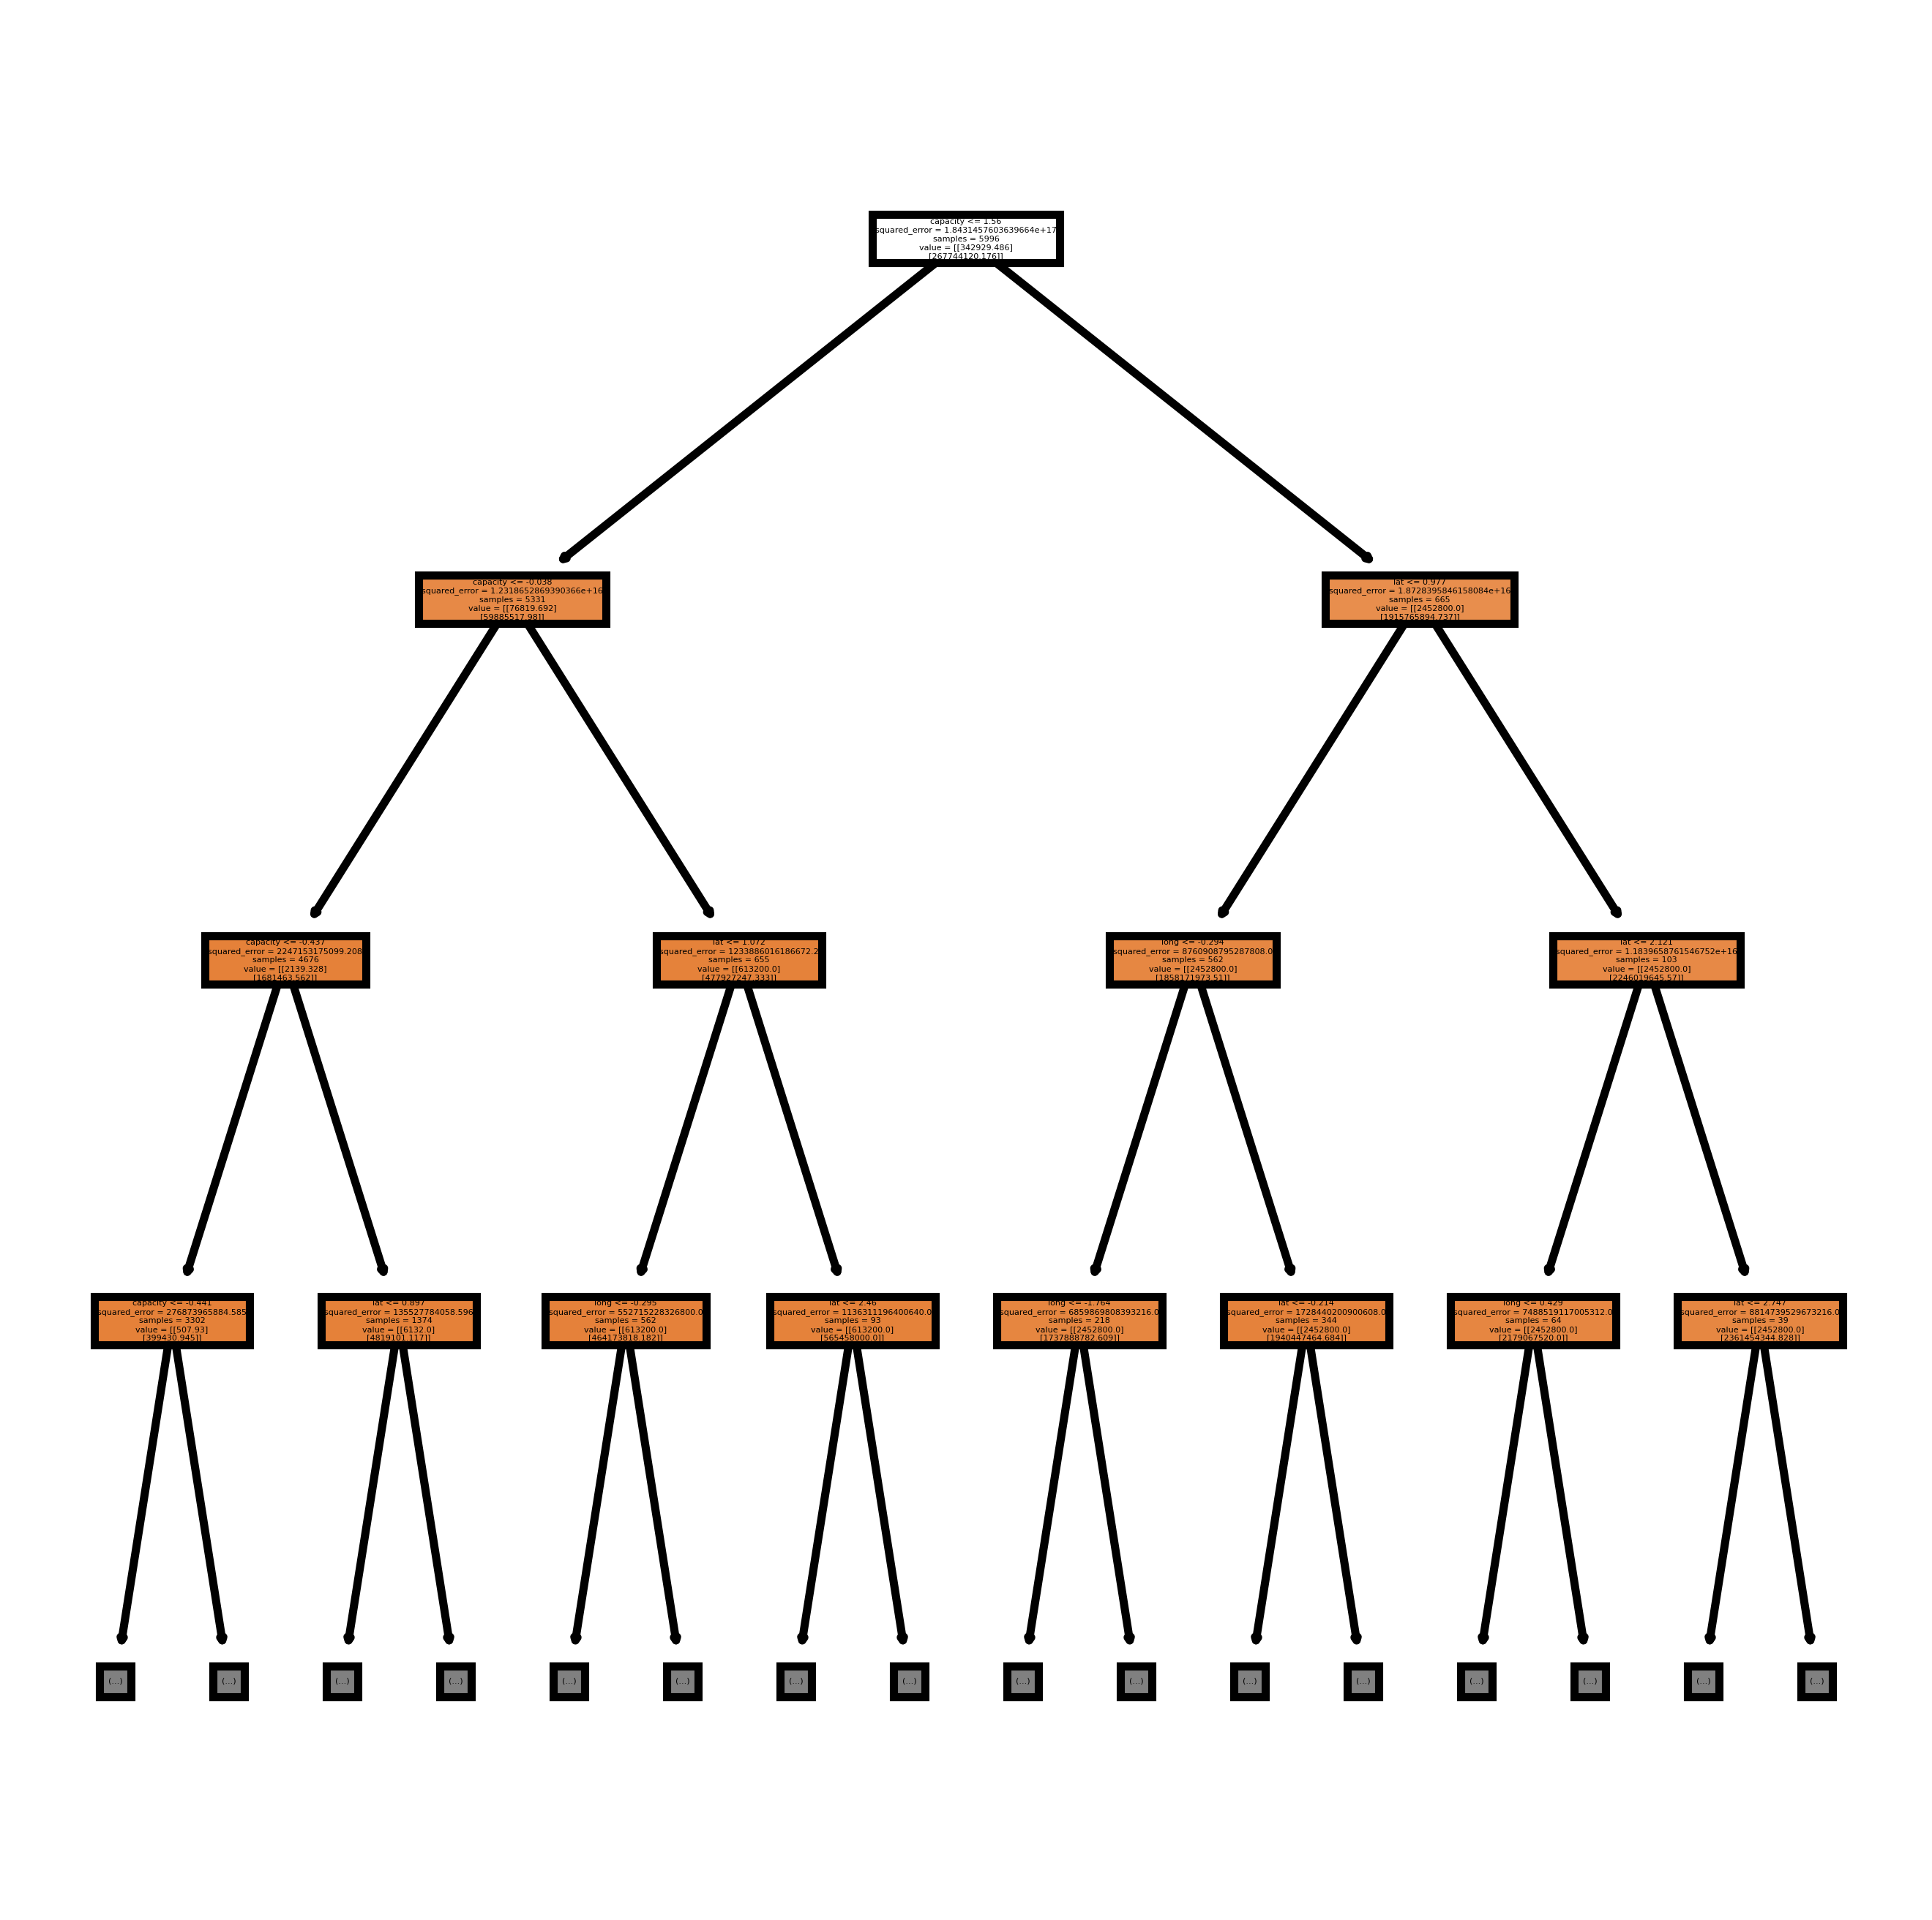

In [16]:
#| label: fig-decision-tree

fn = ['lat','long','capacity']
cn = ['generated_energy','cost']
plt.subplots(nrows=1, ncols=1, figsize=(4,4), dpi=800)
tree.plot_tree(reg.estimators_[0],feature_names=fn,class_names=cn,filled=True, max_depth=3)
plt.show()